In [1]:
# 라이브러리 불러오기
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 1. 데이터 불러오기
df = pd.read_csv("C:/Users/LG/OneDrive/문서/GitHub/KBO_Prediction_ML/data/real_final.csv")  # 경로는 필요에 따라 수정하세요

In [3]:
# 2. 결측치 확인
print(df.isnull().sum())

GameDate              0
home_Team             0
away_Team             0
Result                0
home_Recent_5_Win     0
home_Recent_5_Loss    0
home_OPS              0
home_BB               0
home_HBP              0
home_SO               0
home_ERA              0
home_BB_p             0
home_K                0
home_IR               0
home_IS               0
home_TBF              0
away_OPS              0
away_BB               0
away_HBP              0
away_SO               0
away_ERA              0
away_BB_p             0
away_K                0
away_IR               0
away_IS               0
away_TBF              0
dtype: int64


In [ ]:
# 3. 문자열 타입(만약 있으면) 인코딩 (예: home_Team, away_Team가 숫자형이라면 생략 가능)
# LabelEncoder 적용. 
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [5]:
# 4. feature와 label 나누기
df = df.drop(columns=['GameDate'])
X = df.drop(columns=['Result'])
y = df['Result']

In [6]:
# 5. 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3, stratify=y)

In [7]:
# 6. 반복문으로 하이퍼파라미터 조합 탐색 및 평가
best_acc = 0
best_params = {}
best_model = None

n_estimators_list = [100, 200]
max_depth_list = [10, 20, None]
min_samples_split_list = [2, 5]
min_samples_leaf_list = [1, 2]
max_features_list = ['sqrt', 'log2']

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        for min_samples_split in min_samples_split_list:
            for min_samples_leaf in min_samples_leaf_list:
                for max_features in max_features_list:
                    model = RandomForestClassifier(
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf,
                        max_features=max_features,
                        random_state=3
                    )
                    model.fit(X_train, y_train)
                    y_test_pred = model.predict(X_test)
                    acc = accuracy_score(y_test, y_test_pred)
                    if acc > best_acc:
                        best_acc = acc
                        best_params = {
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'min_samples_split': min_samples_split,
                            'min_samples_leaf': min_samples_leaf,
                            'max_features': max_features
                        }
                        best_model = model
print("최고 정확도:", best_acc)
print("최적 파라미터:", best_params)

최고 정확도: 0.8754098360655738
최적 파라미터: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


In [8]:
# 7. 최적 모델로 train/test 정확도, AUC 출력
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
y_train_proba = best_model.predict_proba(X_train)[:, 1]
y_test_proba = best_model.predict_proba(X_test)[:, 1]

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Train AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

Train Accuracy: 0.9988
Test Accuracy: 0.8754
Train AUC: 1.0000
Test AUC: 0.9371


In [9]:
# 8. 상세 분류 리포트 출력 (테스트 데이터 기준)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87       294
           1       0.88      0.87      0.88       316

    accuracy                           0.88       610
   macro avg       0.88      0.88      0.88       610
weighted avg       0.88      0.88      0.88       610



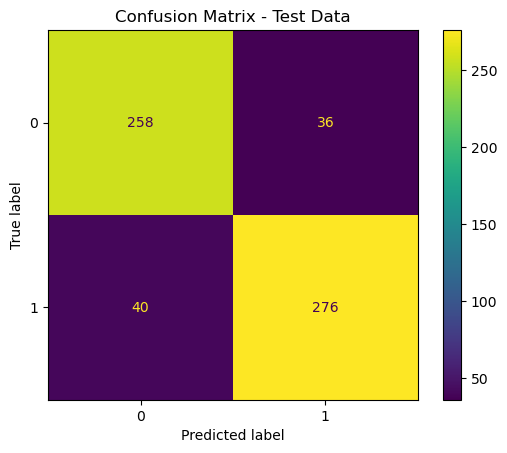

In [10]:
# 9. Confusion Matrix 시각화
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.title("Confusion Matrix - Test Data")
plt.show()

In [ ]:
# 10. ROC Curve 시각화
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title("ROC Curve - Test Data")
plt.show()

In [ ]:
# 11. Feature Importance 시각화
importances = best_model.feature_importances_
features = X.columns
feature_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df)
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

In [ ]:
# 12. 모델 저장
joblib.dump(best_model, 'best_random_forest_model_manual.pkl')
print("모델이 'best_random_forest_model_manual.pkl' 파일로 저장되었습니다.")